<hr style="height:5px;border-width:0;color:orange;background-color:orange">
    <center> <span style="font-size: 38px;"> Sales Store prediction with Prophet </span> </center>

+ Author: **Alejandro Sánchez Silvestre**
+ Date: **April 2024**
+ Module: **Time Series with Prophet (Meta)**

<hr style="height:5px;border-width:0;color:orange;background-color:orange">

<a id='seccion1'></a>
# **1.Intro**



Los datos pertenecen a las ventas semanales de una cadena de supermercados en la costa este de EEUU. En los datos tenemos unas 10 tiendas distribuidas en tres ciudades (New York, Boston y Philadelphia) con un historico de ventas desde 2011 hasta primer trimestre de 2016.

El objetivo será **predecir las ventas de cada tienda hasta 2017**.

Los datos son limpios y estructurados, no nos centraremos en hacer un EDA ni profundizar en el preprocesamiento. La idea es centrarse en el modelaje con Prophet de Meta.


**3. Análisis de Resultados y Selección de Modelo**
- Comparación de modelos.
- Selección de modelo basada en criterios y métricas.

**ROAD MAP Y OUTLINE**:
- **Intro**
- **Pipeline summary**:
    1. **Comprensión del problema/negocio**
    2. **Entendimiento de los datos**
        - Énfasis en variables temporales y estacionalidad.
        - Análisis de autocorrelación y autocorrelación parcial.
        - Descomposición de los componentes de la serie temporal
    3. **Preprocesamiento**: tratamiento de datos y tipos, fechas, nulos, duplicados y feature engeneering si necesario.
    4. **Modelización**: Desarrollo de Métodos (SARIMAX, Prophet, Boosting, Otros)
    5. **Evaluacion resultados**:
        - Comparación de modelos.
        - Selección de modelo basada en criterios y métricas. XGBoost con 7 features importantes + target
   

## **Libraries**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [49]:

# Generales
import pandas as pd
import datetime as dt
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Modelaje
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error,r2_score


In [50]:
!pip install scikit-optimize

In [51]:
# Tuneo hiperparametros (importado más abajo, necesaria instalacion de skopt)
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [52]:
df= pd.read_csv('sales_data_stores.csv',index_col=0,parse_dates=True)
df

<ipython-input-52-01a3129852f7>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df= pd.read_csv('sales_data_stores.csv',index_col=0,parse_dates=True)


date                 item       category       department  \
0        2013-07-08     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
1        2013-07-15     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
2        2013-07-22     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
3        2013-07-29     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
4        2013-08-05     ACCESORIES_1_001     ACCESORIES     ACCESORIES_1   
...             ...                  ...            ...              ...   
2427548  2012-04-16  HOME_&_GARDEN_2_029  HOME_&_GARDEN  HOME_&_GARDEN_2   
2427549  2012-04-23  HOME_&_GARDEN_2_029  HOME_&_GARDEN  HOME_&_GARDEN_2   
2427550  2012-04-30  HOME_&_GARDEN_2_029  HOME_&_GARDEN  HOME_&_GARDEN_2   
2427551  2012-05-07  HOME_&_GARDEN_2_029  HOME_&_GARDEN  HOME_&_GARDEN_2   
2427552  2012-05-14  HOME_&_GARDEN_2_029  HOME_&_GARDEN               HO   

                   stores    region  week    year  is_holidays  units_sold  \
0        South_End(BOS_1)    Boston  28.0  2013.0          0.0         0.0   
1        South_End(BOS_1)    Boston  28.0  2013.0          1.0         0.0   
2        South_End(BOS_1)    Boston  29.0  2013.0          0.0         4.0   
3        South_End(BOS_1)    Boston  30.0  2013.0          0.0         6.0   
4        South_End(BOS_1)    Boston  31.0  2013.0          0.0         0.0   
...                   ...       ...   ...     ...          ...         ...   
2427548    Tribeca(NYC_3)  New York  15.0  2012.0          0.0         5.0   
2427549    Tribeca(NYC_3)  New York  16.0  2012.0          0.0         5.0   
2427550    Tribeca(NYC_3)  New York  17.0  2012.0          0.0         6.0   
2427551    Tribeca(NYC_3)  New York  18.0  2012.0          0.0         9.0   
2427552               NaN       NaN   NaN     NaN          NaN         NaN   

         sell_price  total_sales  
0           12.7414       0.0000  
1           12.7414       0.0000  
2           10.9858      43.9432  
3           10.9858      65.9148  
4           10.9858       0.0000  
...             ...          ...  
2427548     13.7125      68.5625  
2427549     13.7125      68.5625  
2427550     13.7125      82.2750  
2427551     13.7125     123.4125  
2427552         NaN          NaN  

[2427553 rows x 12 columns]

In [53]:
# Visualizamos cuantas tiendas tenemos
df.stores.unique()


array(['South_End(BOS_1)', 'Roxbury(BOS_2)', 'Back_Bay(BOS_3)',
       'Greenwich_Village(NYC_1)', 'Harlem(NYC_2)', 'Tribeca(NYC_3)',
       'Brooklyn(NYC_4)', 'Midtown_Village(PHI_1)', 'Yorktown(PHI_2)',
       'Queen_Village(PHI_3)', nan], dtype=object)

In [54]:
# Visualizamos cuantas regiones tenemos
df.region.unique()

array(['Boston', 'New York', 'Philadelphia', nan], dtype=object)


<a id='seccion2'></a>
# **2. Eventos**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


Unas de las ventajas de Prophet respecto a otros modelos de prediccion es su simplicidad y accesibilidad al usuario. Adicionalmente prophet permite modelar utilizando eventos externos para impactarlos sobre la prediccion.

Prophet modela la serie temporal y(t) con tres componentes principales: tendencia (g) , seasonality(s)  y eventos(holiday, h) mas el error (ϵ)

La fórmula general que utiliza es:

y(t)=g(t)+s(t)+h(t)+ϵ

Una de las ventajas de prophet es que no necesitamos procesar los datos temporales de la misma forma tediosa que necesitan los modelos como ARIMA o basados en boosting (XGBoost, CatBoost...) simplemente con una fecha y un valor a predecir Prophet es capaz de funcionar, siempre y cuando lo formateemos adecuadamente.
​


In [55]:
# Prophet funciona mejor con eventos, asi que extraeremos los eventos mas importantes de nuestro csv de eventos.

df_events= pd.read_csv('daily_calendar_with_events.csv')
df_events

date    weekday  weekday_int       d event
0     2011-01-29   Saturday            1     d_1   NaN
1     2011-01-30     Sunday            2     d_2   NaN
2     2011-01-31     Monday            3     d_3   NaN
3     2011-02-01    Tuesday            4     d_4   NaN
4     2011-02-02  Wednesday            5     d_5   NaN
...          ...        ...          ...     ...   ...
1908  2016-04-20  Wednesday            5  d_1909   NaN
1909  2016-04-21   Thursday            6  d_1910   NaN
1910  2016-04-22     Friday            7  d_1911   NaN
1911  2016-04-23   Saturday            1  d_1912   NaN
1912  2016-04-24     Sunday            2  d_1913   NaN

[1913 rows x 5 columns]

In [56]:
# extraemos el df con los eventos filtrados:

df_events.dropna(inplace=True)

# cambiamos las columans para el prophet

df_events.rename(columns={'date':'ds','event':'holiday'},inplace=True)

df_events['ds']=pd.to_datetime(df_events['ds'])

# eliminamos las columnas que no interesan
df_events.drop(columns=['weekday','weekday_int','d'],inplace=True)
df_events

ds         holiday
8    2011-02-06       SuperBowl
184  2011-08-01  Ramadan starts
299  2011-11-24    Thanksgiving
337  2012-01-01         NewYear
372  2012-02-05       SuperBowl
435  2012-04-08          Easter
538  2012-07-20  Ramadan starts
663  2012-11-22    Thanksgiving
703  2013-01-01         NewYear
736  2013-02-03       SuperBowl
792  2013-03-31          Easter
892  2013-07-09  Ramadan starts
1034 2013-11-28    Thanksgiving
1068 2014-01-01         NewYear
1100 2014-02-02       SuperBowl
1177 2014-04-20          Easter
1247 2014-06-29  Ramadan starts
1398 2014-11-27    Thanksgiving
1433 2015-01-01         NewYear
1464 2015-02-01       SuperBowl
1527 2015-04-05          Easter
1601 2015-06-18  Ramadan starts
1762 2015-11-26    Thanksgiving
1798 2016-01-01         NewYear
1835 2016-02-07       SuperBowl
1884 2016-03-27          Easter

## **Nuevos eventos**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Como nuestra region es la costa este de EEUU, aparte de los eventos que están dentro de nuestra df_events (Superbowl, Easter, Ramadan...) buscaremos otros eventos tambien importantes basandonos en la cultura norteamericana. Como los datos a predecir se basan en las ventas de una cadena de supermercados, buscaremos situaciones en las que se de un aumento de venta debido a un evento o festividad.


Seleccionaremos los siguientes:

Eventos comerciales/festivos
- Black Friday
- Halloween
- 4th July, dia de la independencia norteamericana
- San valentín
- Dia de la madre y del padre
- Navidades

Festividades religiosas:
Ya que nuestra df_events incluye Ramadan, añadiremos tambien Hannukah y Diwali, en el caso de NY, existe un 5%, 3% y 2%  de poblacion Judia, Musulmana e Hindi.
- Hannukah: Judia
- Diwali: Hindi
- Eid-al-Fitr: Fin del ramadan, Musulmana.

Otras eventos locales:
- NYC Marathon
- NYC Pride
- Boston Marathon

In [57]:
# Aparte añadiremos otros eventos importantes y fechas que se han producido en las tres ciudades.

eventos = [
    {'fecha': '2011-11-25', 'evento': 'Black Friday'},
    {'fecha': '2012-11-23', 'evento': 'Black Friday'},
    {'fecha': '2013-11-29', 'evento': 'Black Friday'},
    {'fecha': '2014-11-28', 'evento': 'Black Friday'},
    {'fecha': '2015-11-27', 'evento': 'Black Friday'},
    {'fecha': '2016-11-25', 'evento': 'Black Friday'},
    {'fecha': '2017-11-24', 'evento': 'Black Friday'},
    {'fecha': '2011-10-31', 'evento': 'Halloween'},
    {'fecha': '2012-10-31', 'evento': 'Halloween'},
    {'fecha': '2013-10-31', 'evento': 'Halloween'},
    {'fecha': '2014-10-31', 'evento': 'Halloween'},
    {'fecha': '2015-10-31', 'evento': 'Halloween'},
    {'fecha': '2016-10-31', 'evento': 'Halloween'},
    {'fecha': '2017-10-31', 'evento': 'Halloween'},
    {'fecha': '2011-07-04', 'evento': 'Independence Day'},
    {'fecha': '2012-07-04', 'evento': 'Independence Day'},
    {'fecha': '2013-07-04', 'evento': 'Independence Day'},
    {'fecha': '2014-07-04', 'evento': 'Independence Day'},
    {'fecha': '2015-07-04', 'evento': 'Independence Day'},
    {'fecha': '2016-07-04', 'evento': 'Independence Day'},
    {'fecha': '2017-07-04', 'evento': 'Independence Day'},
    {'fecha': '2011-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2012-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2013-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2014-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2015-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2016-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2017-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2011-05-08', 'evento': "Mother's Day"},
    {'fecha': '2012-05-13', 'evento': "Mother's Day"},
    {'fecha': '2013-05-12', 'evento': "Mother's Day"},
    {'fecha': '2014-05-11', 'evento': "Mother's Day"},
    {'fecha': '2015-05-10', 'evento': "Mother's Day"},
    {'fecha': '2016-05-08', 'evento': "Mother's Day"},
    {'fecha': '2017-05-14', 'evento': "Mother's Day"},
    {'fecha': '2011-06-19', 'evento': "Father's Day"},
    {'fecha': '2012-06-17', 'evento': "Father's Day"},
    {'fecha': '2013-06-16', 'evento': "Father's Day"},
    {'fecha': '2014-06-15', 'evento': "Father's Day"},
    {'fecha': '2015-06-21', 'evento': "Father's Day"},
    {'fecha': '2016-06-19', 'evento': "Father's Day"},
    {'fecha': '2017-06-18', 'evento': "Father's Day"},
    {'fecha': '2011-12-25', 'evento': "Christmas"},
    {'fecha': '2012-12-25', 'evento': "Christmas"},
    {'fecha': '2013-12-25', 'evento': "Christmas"},
    {'fecha': '2014-12-25', 'evento': "Christmas"},
    {'fecha': '2015-12-25', 'evento': "Christmas"},
    {'fecha': '2016-12-25', 'evento': "Christmas"},
    {'fecha': '2017-12-25', 'evento': "Christmas"},
    {'fecha': '2011-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2012-11-04', 'evento': 'NYC Marathon'},
    {'fecha': '2013-11-03', 'evento': 'NYC Marathon'},
    {'fecha': '2014-11-02', 'evento': 'NYC Marathon'},
    {'fecha': '2015-11-01', 'evento': 'NYC Marathon'},
    {'fecha': '2016-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2017-11-05', 'evento': 'NYC Marathon'},
    {'fecha': '2011-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2012-04-16', 'evento': 'Boston Marathon'},
    {'fecha': '2013-04-15', 'evento': 'Boston Marathon'},
    {'fecha': '2014-04-21', 'evento': 'Boston Marathon'},
    {'fecha': '2015-04-20', 'evento': 'Boston Marathon'},
    {'fecha': '2016-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2017-04-17', 'evento': 'Boston Marathon'},
    {'fecha': '2011-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2012-06-24', 'evento': 'NYC Pride'},
    {'fecha': '2013-06-30', 'evento': 'NYC Pride'},
    {'fecha': '2014-06-29', 'evento': 'NYC Pride'},
    {'fecha': '2015-06-28', 'evento': 'NYC Pride'},
    {'fecha': '2016-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2017-06-25', 'evento': 'NYC Pride'},
    {'fecha': '2011-08-30', 'evento': "Eid al-Fitr"},
    {'fecha': '2012-08-19', 'evento': "Eid al-Fitr"},
    {'fecha': '2013-08-08', 'evento': "Eid al-Fitr"},
    {'fecha': '2014-07-28', 'evento': "Eid al-Fitr"},
    {'fecha': '2015-07-17', 'evento': "Eid al-Fitr"},
    {'fecha': '2016-07-06', 'evento': "Eid al-Fitr"},
    {'fecha': '2017-06-25', 'evento': "Eid al-Fitr"},
    {'fecha': '2011-12-20', 'evento': 'Hanukkah'},
    {'fecha': '2012-12-08', 'evento': 'Hanukkah'},
    {'fecha': '2013-11-27', 'evento': 'Hanukkah'},
    {'fecha': '2014-12-16', 'evento': 'Hanukkah'},
    {'fecha': '2015-12-06', 'evento': 'Hanukkah'},
    {'fecha': '2016-12-24', 'evento': 'Hanukkah'},
    {'fecha': '2017-12-12', 'evento': 'Hanukkah'},
    {'fecha': '2011-10-26', 'evento': 'Diwali'},
    {'fecha': '2012-11-13', 'evento': 'Diwali'},
    {'fecha': '2013-11-03', 'evento': 'Diwali'},
    {'fecha': '2014-10-23', 'evento': 'Diwali'},
    {'fecha': '2015-11-11', 'evento': 'Diwali'},
    {'fecha': '2016-10-30', 'evento': 'Diwali'},
    {'fecha': '2017-10-19', 'evento': 'Diwali'}
]


In [58]:
# y creamos df con los eventos nuevos.

df_new_events= pd.DataFrame(eventos)

# cambiamos columnas para que sean las mismas que para nuestra futura df para prophet ya que el modelo necesita que
# los nombres de las columnas sean 'ds' para el tiempo y 'holiday' para los eventos o vacaciones.
df_new_events.rename(columns={'fecha':'ds','evento':'holiday'},inplace=True)
# y el formato datetime
df_new_events['ds']=pd.to_datetime(df_new_events['ds'])


df_new_events

ds       holiday
0  2011-11-25  Black Friday
1  2012-11-23  Black Friday
2  2013-11-29  Black Friday
3  2014-11-28  Black Friday
4  2015-11-27  Black Friday
..        ...           ...
86 2013-11-03        Diwali
87 2014-10-23        Diwali
88 2015-11-11        Diwali
89 2016-10-30        Diwali
90 2017-10-19        Diwali

[91 rows x 2 columns]

In [59]:
# concatenamos las dos dataframes

df_events = pd.concat([df_events, df_new_events], ignore_index=True)
# y ya tendriamos nuestra df con los todos los eventos a incluir en el modelo Prophet.
df_events

ds         holiday
0   2011-02-06       SuperBowl
1   2011-08-01  Ramadan starts
2   2011-11-24    Thanksgiving
3   2012-01-01         NewYear
4   2012-02-05       SuperBowl
..         ...             ...
112 2013-11-03          Diwali
113 2014-10-23          Diwali
114 2015-11-11          Diwali
115 2016-10-30          Diwali
116 2017-10-19          Diwali

[117 rows x 2 columns]

## División datos por tienda
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Prophet para modelar necesita unicamente dos columnas, el tiempo(ds) y la variable a predecir (y), en nuestro caso el valor de venta.
Por eso necesitaremos dividir nuestra df inicial en 10 subsecuentes dataframes para cada tienda (10 en total)

In [60]:
# Creamos 10 df con los datos de las distintas tiendas para hacer las distintas predicciones adaptando los datos para prophet:

# recordemos que los nombres de las columnas han de ser especificos para prophet, 'ds' y 'y' y que 'ds' ha de ser datetime.


df.rename(columns={'date':'ds','total_sales':'y'},inplace=True)
df['ds']=pd.to_datetime(df['ds'])

# Creamos los df para cada tienda agrupando ventas por dia.

# BO

df_prophet_BOS_1_South_End= df[df['stores'] == 'South_End(BOS_1)'].groupby('ds')['y'].sum().reset_index()
df_prophet_BOS_2_Roxbury= df[df['stores'] == 'Roxbury(BOS_2)'].groupby('ds')['y'].sum().reset_index()
df_prophet_BOS_3_Back_Bay= df[df['stores'] == 'Back_Bay(BOS_3)'].groupby('ds')['y'].sum().reset_index()

# NY

df_prophet_NYC_1_Greenwich_Village= df[df['stores'] == 'Greenwich_Village(NYC_1)'].groupby('ds')['y'].sum().reset_index()
df_prophet_NYC_2_Harlem= df[df['stores'] == 'Harlem(NYC_2)'].groupby('ds')['y'].sum().reset_index()
df_prophet_NYC_3_Tribeca= df[df['stores'] == 'Tribeca(NYC_3)'].groupby('ds')['y'].sum().reset_index()
df_prophet_NYC_4_Brooklyn= df[df['stores'] == 'Brooklyn(NYC_4)'].groupby('ds')['y'].sum().reset_index()

# PHI

df_prophet_PHI_1_Midtown_Village= df[df['stores'] == 'Midtown_Village(PHI_1)'].groupby('ds')['y'].sum().reset_index()
df_prophet_PHI_2_Yorktown= df[df['stores'] == 'Yorktown(PHI_2)'].groupby('ds')['y'].sum().reset_index()
df_prophet_PHI_3_Queen_Village= df[df['stores'] == 'Queen_Village(PHI_3)'].groupby('ds')['y'].sum().reset_index()


# visualizamos un ejemplo
df_prophet_BOS_1_South_End


ds           y
0   2011-01-31   1676.0336
1   2011-02-07  13576.6183
2   2011-02-14  15353.5774
3   2011-02-21  17900.0972
4   2011-02-28  15859.1238
..         ...         ...
269 2016-03-28  35571.0029
270 2016-04-04  36826.4506
271 2016-04-11  37396.5273
272 2016-04-18  33577.3895
273 2016-04-25  31222.3435

[274 rows x 2 columns]

<Axes: xlabel='ds', ylabel='y'>

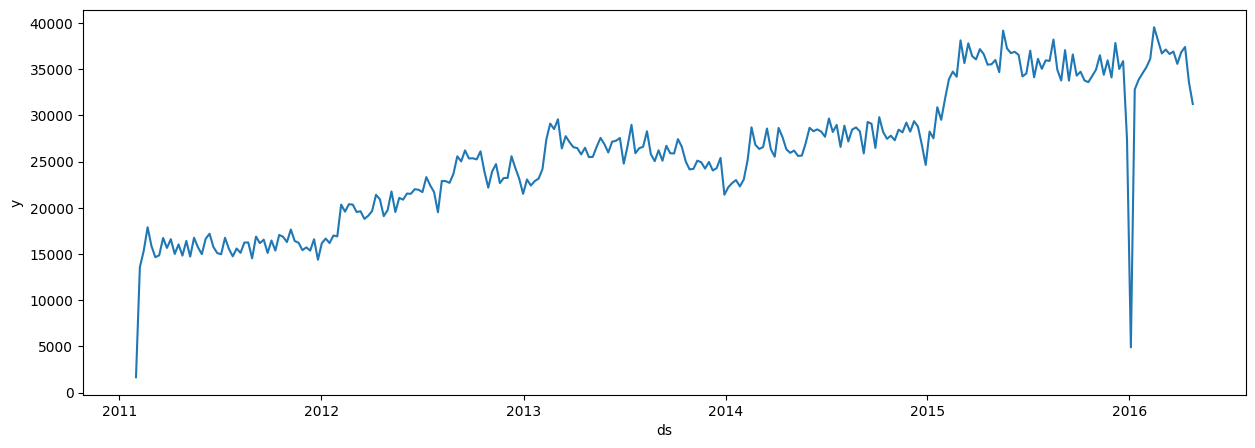

In [61]:
# vamos a representar graficamente las ventas a lo largo del tiempo de la tienda de South_End (Boston).
plt.figure(figsize=(15, 5))


sns.lineplot(data=df_prophet_BOS_1_South_End,x='ds',y='y')

<Axes: xlabel='ds', ylabel='y'>

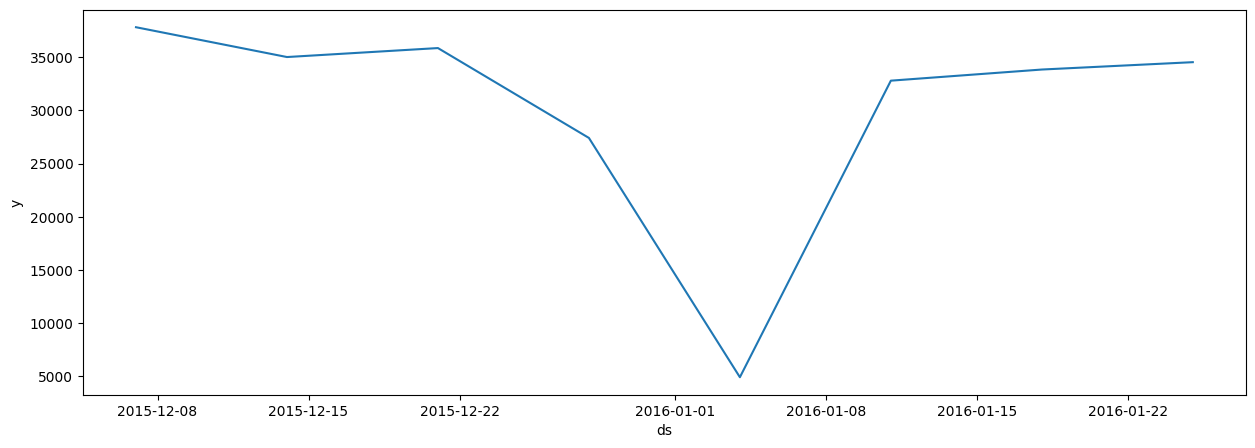

In [62]:
# visualizamos en concreto los meses de diciembre 2015 y enero 2016

plt.figure(figsize=(15, 5))
sns.lineplot(data= df_prophet_BOS_1_South_End[(df_prophet_BOS_1_South_End['ds'] >= '2015-12-01') & (df_prophet_BOS_1_South_End['ds'] <= '2016-01-31')],x='ds',y='y')


# vemos que para el 10 de enero de 2016 existe un descenso en ventas considerable. No se si podria deberse a una tormenta invernal

# Tras una busqueda en internet vemos que en enero de 2016 fue el mes en el que ocurrió una gran tormenta de nieve en Estados Unidos (Supertormenta Jonas) , afectando principalmente a la región
# del Atlántico Medio y el Noreste, incluyendo ciudades como Washington D.C., Filadelfia y Nueva York con 1-2.5 pies (12-30 pulgadas) de nieve​ (https://en.wikipedia.org/wiki/January_2016_United_States_blizzard)​.


# he revisado en NY y pasa mas de lo mismo, asi que podria tener sentido. Añadimos el evento

In [63]:
# Añadimos el evento de la supertormenta a nuestro df_events


# Crear un nuevo DataFrame con la fila que deseas agregar
new_row = pd.DataFrame({'ds': [pd.to_datetime('2016-01-07')], 'holiday': ['Jonas Superstorm']})

# Concatenar el nuevo DataFrame con df_events
df_events = pd.concat([df_events, new_row], ignore_index=True)

# Verificar el DataFrame resultante
display(df_events)

ds           holiday
0   2011-02-06         SuperBowl
1   2011-08-01    Ramadan starts
2   2011-11-24      Thanksgiving
3   2012-01-01           NewYear
4   2012-02-05         SuperBowl
..         ...               ...
113 2014-10-23            Diwali
114 2015-11-11            Diwali
115 2016-10-30            Diwali
116 2017-10-19            Diwali
117 2016-01-07  Jonas Superstorm

[118 rows x 2 columns]


<a id='seccion3'></a>
# **3. Modelaje con Prophet**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


Una vez que ya tenemos las df independientes de cada tienda, los eventos correctamente asignado y todo ello siguiendo el formato necesario para prophet (columnas correctamente nombradas, fecha en datetime...) vamos a pasar al modelaje.

Para esta seccion definiremos una funcion que integre todas las df de cada tienda y modele de forma individual las ventas de cada una.

Pero antes de nada, para poder comparar posteriormente el efecto de los eventos, tiraremos en bruto un primer modelo de prophet.


## **Prophet raw**

In [64]:
# tiramos un primer modelo sin ajustar para nuestra tienda de ejempo (South End)

# Creamos el modelo
model_raw = Prophet()

# Ajustamos el modelo
model_raw.fit(df_prophet_BOS_1_South_End)

# Creamos un dataframe con las fechas futuras, en nuestro caso como tenemos las ventass por semana, ajustaremos hasta 2017, es decir unas 38 semanas
future = model_raw.make_future_dataframe(periods=38 , freq='W')

# Realizamos la prediccion
df_pred_BOS_1_South_End = model_raw.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/s62bx7ln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/g_klhcjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19758', 'data', 'file=/tmp/tmpwd4td7hn/s62bx7ln.json', 'init=/tmp/tmpwd4td7hn/g_klhcjz.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modeltsxyrakp/prophet_model-20240411164941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'South End -Boston(1) - MAPE: 0.10%, R2: 0.88')

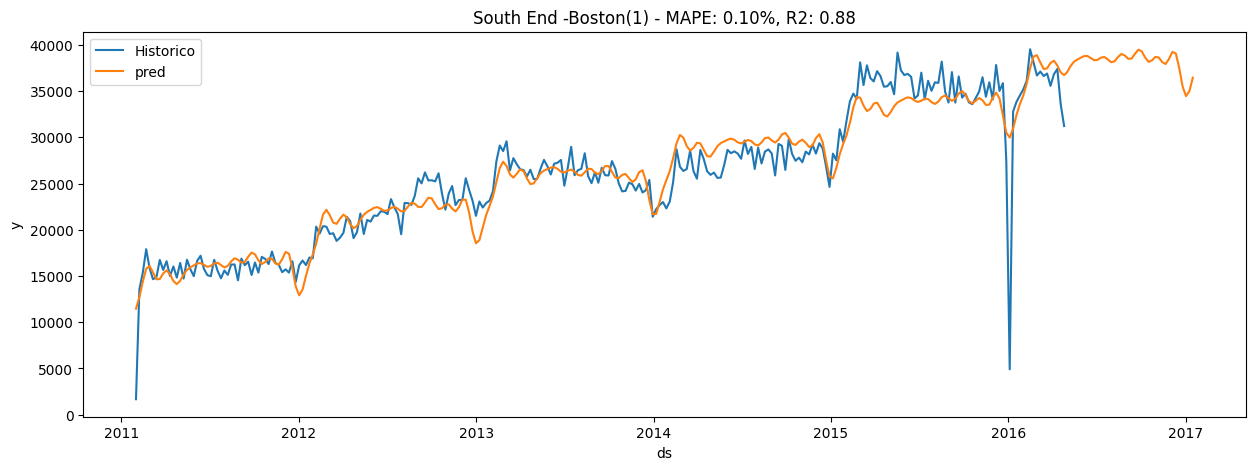

In [65]:
# representamos la prediccion respecto a los datos reales

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1_South_End,x='ds',y='y',label='Historico')

sns.lineplot(data=df_pred_BOS_1_South_End,x='ds',y='yhat',label='pred')

# Para calcular el MAPE necesitamos filtrar la prediccion a las fechas presentes en el historico
df_pred_filtered = df_pred_BOS_1_South_End[df_pred_BOS_1_South_End['ds'].isin(df_prophet_BOS_1_South_End['ds'])]
y_pred = df_pred_filtered['yhat']
y_true = df_prophet_BOS_1_South_End['y']

# Calculamos el MAPE y R2
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Añadimos el título con la tienda y metricas
plt.title(f'South End -Boston(1) - MAPE: {mape:.2f}%, R2: {r2:.2f}')

Como hemos podido comprobar las predicciones no son particularmente precisas dejando muchos minimos y maximos sin cubrir.

Adicionalmente tenemos un MAPE del 26%, bastante inexacta la prediccion aunque mas o menos sigue la tendencia de las ventas (malamente).

Estas metricas no me sorprenden ya que aun no hemos ni añadido las vacaciones del pais (US) ni nuestros eventos importantes (df_events).


Pasemos a seguir con la funcion que englobe todas las tiendas y modele predicciones.

In [66]:
# Primeramente creamos a su vez un df_global para ver las predicciones globales y compararlas con las individuales por tienda
# incluiremos esto mas abajo en la funcion prophet_store_prediction.

# Creamos un df global con ventas totales por semana, formateando ya para prophet
df_global=pd.read_csv('sales_data_stores.csv',index_col=0)
df_global_prophet= df_global.groupby('date')['total_sales'].sum().reset_index()
df_global_prophet.rename(columns={'date':'ds','total_sales':'y'},inplace=True)
df_global_prophet['ds']=pd.to_datetime(df_global_prophet['ds'])
df_global_prophet

ds            y
0   2011-01-31   22479.6891
1   2011-02-07  173170.3274
2   2011-02-14  185292.5724
3   2011-02-21  202996.0753
4   2011-02-28  185012.6416
..         ...          ...
269 2016-03-28  408345.3158
270 2016-04-04  454676.6940
271 2016-04-11  439963.8949
272 2016-04-18  414423.5151
273 2016-04-25  375651.0666

[274 rows x 2 columns]

## **Prediccion multitienda - Creación funcion prediccion prophet**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Como la idea es hacer predicciones pero tambien ir iterando con nuevos parametros y ajustar lo que consideremos, crearemos una funcion que nos permita repetir, visualizar y almacenar resultados de cara a tomar decisiones en un futuro.

In [67]:
# creamos un diccionario de tiendas para que la funcion vaya iterando por cada una de ellas

dict_tienda= {'South_End_BOS_1': df_prophet_BOS_1_South_End,
                'Roxbury_BOS_2': df_prophet_BOS_2_Roxbury,
                'Back_Bay_BOS_3': df_prophet_BOS_3_Back_Bay,
                'Greenwich_Village_NYC_1': df_prophet_NYC_1_Greenwich_Village,
                'Harlem_NYC_2': df_prophet_NYC_2_Harlem,
                'Tribeca_NYC_3': df_prophet_NYC_3_Tribeca,
                'Brooklyn_NYC_4': df_prophet_NYC_4_Brooklyn,
                'Midtown_Village_PHI_1': df_prophet_PHI_1_Midtown_Village,
                'Yorktown_PHI_2': df_prophet_PHI_2_Yorktown,
                'Queen_Village_PHI_3': df_prophet_PHI_3_Queen_Village,
                'Global sales':df_global_prophet}

In [68]:
# creamos una funcion que nos permita hacer las predicciones con prophet por cada tienda independientemente y podamos volver a ejecutarla mas
# tarde de cara al deploy en MLOps (se pueda actualizar con nuevos datos)


'''
Documentacion funcion prophet_store_prediction(dict_tienda, df_events, periods_weeks):

Esta función ajusta un modelo de Prophet para cada tienda contenida en el diccionario dict_tienda,
teniendo en cuenta eventos especiales (df_events) y haciendo predicciones para un número definido
de semanas en el futuro (periods_weeks).

Las predicciones, se visualizan en subplots para facilitar la comparación entre tiendas. Además, se calcula el MAPE
y el R2 para evaluar la precisión de las predicciones en el conjunto de datos históricos.

Finalmente, se retorna un DataFrame con las predicciones futuras, tendencias y valores históricos para cada tienda.

Parámetros:
    - dict_tienda (dict): Diccionario con nombres de tiendas como claves y DataFrames como valores. Cada DataFrame debe tener columnas 'ds' y 'y'.

    - df_events (DataFrame): DataFrame de eventos especiales que pueden afectar las predicciones, con columnas 'holiday' y 'ds'.
    - periods_weeks (int): Número de semanas hacia el futuro para generar predicciones.

Devuelve:
    - df_predicciones_prophet (DataFrame): DataFrame con predicciones futuras, tendencias, y valores históricos para todas las tiendas.

'''



def prophet_store_prediction(dict_tienda, df_events, periods_weeks):
    # Configurar el tamaño de la figura para los subplots
    plt.figure(figsize=(20, 40))

    # Inicializamos una lista vacía para almacenar los resultados de todas las tiendas
    todas_predicciones = []

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda.items()):

        # Ajustamos ciertos parametros importantes, incluyendo nuestro df_events. Tras Iterar funciona mucho mejor seasonality_mode='multiplicative'
        model= Prophet(holidays=df_events,
                        seasonality_mode='multiplicative', changepoint_prior_scale=0.10,changepoint_range=0.8,
                        seasonality_prior_scale=10, holidays_prior_scale=10, interval_width=0.95)

        # Añadimos las vacaciones de dicho pais
        # model.add_country_holidays(country_name='US')

        model.fit(df_tienda)
        future = model.make_future_dataframe(periods=periods_weeks,freq='W') # Asumiendo periods_weeks se da en semanas
        forecast = model.predict(future)

        # Seleccionamos el subplot adecuado
        ax = plt.subplot(6, 2, idx + 1)

        # Visualizamos los datos históricos y las predicciones
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)

        # Añadimos los intervalos de confianza
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Intervalo de confianza')

        # Agregar las predicciones a la lista
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)


        # Limitamos el cálculo del MAPE y R2 solo a las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = df_tienda['y']
        y_pred = forecasted['yhat']


        # Calculamos el MAPE y R2
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Título del subplot
        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        # Rotar las etiquetas del eje X para mejor lectura
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Concatenar todas las predicciones en un único DataFrame
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/m6dn4m1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/8idx9f4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9955', 'data', 'file=/tmp/tmpwd4td7hn/m6dn4m1_.json', 'init=/tmp/tmpwd4td7hn/8idx9f4h.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelzch9629i/prophet_model-20240411165054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

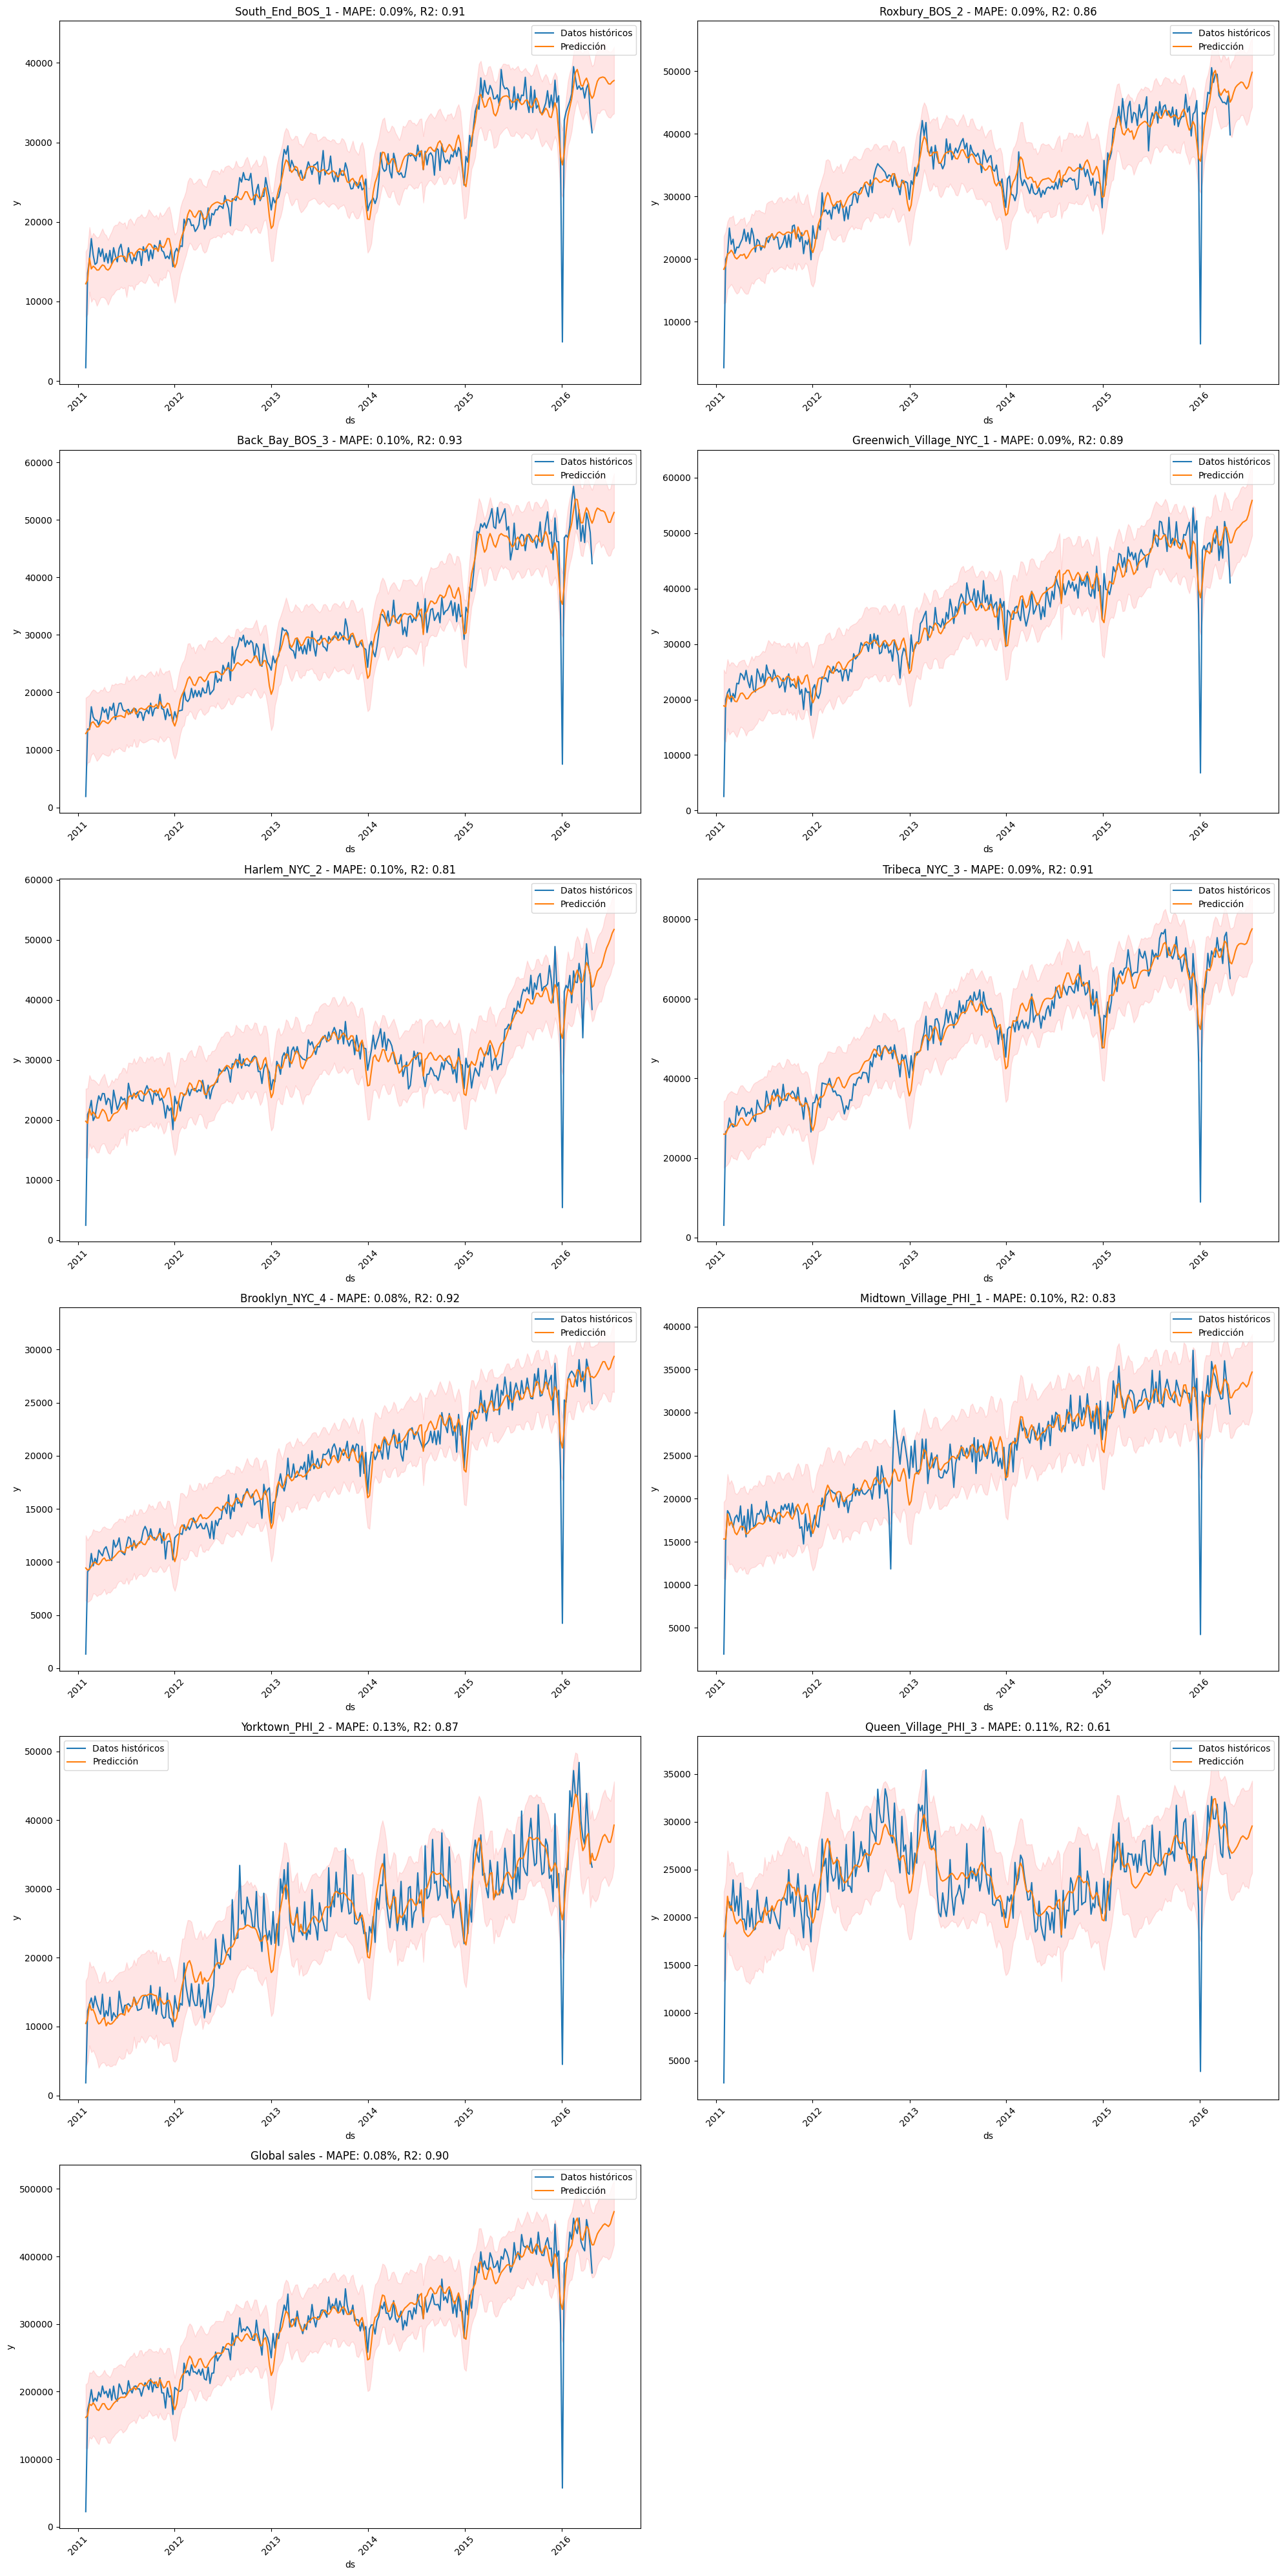

ds            store           yhat          trend     yhat_lower  \
0    2011-01-31  South_End_BOS_1   12225.920484   12602.482951    8054.190277   
1    2011-02-07  South_End_BOS_1   12689.672788   12725.502843    8400.594784   
2    2011-02-14  South_End_BOS_1   15443.505699   12848.522735   11219.228164   
3    2011-02-21  South_End_BOS_1   14102.284219   12971.542627    9935.673412   
4    2011-02-28  South_End_BOS_1   14434.962798   13094.562519   10372.145605   
...         ...              ...            ...            ...            ...   
3141 2016-06-19     Global sales  446526.064818  439984.161373  398626.873868   
3142 2016-06-26     Global sales  444383.724099  441111.906412  395403.239613   
3143 2016-07-03     Global sales  448377.037969  442239.651450  398868.053793   
3144 2016-07-10     Global sales  458407.632400  443367.396489  407532.318774   
3145 2016-07-17     Global sales  466391.709742  444495.141528  417689.971927   

         yhat_upper           y  
0      16275.147634   1676.0336  
1      16746.262579  13576.6183  
2      19352.382976  15353.5774  
3      17966.382900  17900.0972  
4      18613.929842  15859.1238  
...             ...         ...  
3141  493704.600706         NaN  
3142  489840.018456         NaN  
3143  497296.131233         NaN  
3144  506558.610931         NaN  
3145  511182.713022         NaN  

[3146 rows x 7 columns]

In [69]:
# llamamos a la funcion creada y almacenamos resultados en un df.
df_predicciones_prophet = prophet_store_prediction(dict_tienda, df_events, 12)
df_predicciones_prophet



<a id='seccion4'></a>
# **4. Optimizacion del modelo**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

En este apartado trataremos de mejorar las metricas y robusted del modelo a través de diferentes procesos.

Estamos utilizando el MAPE(Mean average percentage error) como metrica para cuantificar el error ya que se interpreta más facil. Esta metrica no podriamos usarla si tuvieramos valores 0 ya que los valores se disparan (por lo de ser un porcentaje).

Para mejorar el MAPE de nuestro modelo anterior, vamos a consideras las siguientes estrategias de ajuste y optimización:


1. **Inclusión de Regresores Adicionales** evaluaremos si podriamos capturar mejor evaluando si existe un patron de compra a lo largo del mes, por ejemplo, si la gente hace la compra mas a principio o final de mes.

2. **Adición de Festividades y Eventos Especiales**: ya incluido

3. **Ajuste de Hiperparámetros**, 
Usaremos una biblioteca de scikit-learn(skopt) ya que prophet en sí no tiene un tuneo automatico como esta biblioteca si, y se nos haría muy tedioso hacerlo manualmente. Esta biblioteca permite hacer una optimizacion de parametros de forma bayesiana. Crearemos un espacio de hiperparametros donde incluiremos los más importantes para prophet:



    - **changepoint_prior_scale**: Aumentar este valor permite al modelo adaptarse más rápidamente a los cambios históricos, pero nos puede llevar a sobreajuste.
    - **seasonality_prior_scale**: Similar al anterior, controla la flexibilidad de la estacionalidad. Ajustaremos este valor puede ayudar a capturar mejor las fluctuaciones estacionales.
    - **holidays_prior_scale**:ajustando este parámetro puede mejorar cómo el modelo considera el impacto de los eventos especiales



4. **Validación Cruzada** esto nos ayudará a minimizar las metricas y a la vez tener un modelo mas robusto y que generalice mejor.Aqui vamos a utilizar validacion cruzada para aumentar la robusted de nuestro modelo. Adicionalmente afinaremos los hiperparametros del modelo para ver si puede mejorar las metricas.




## 4.1 Inclusion de Regresor

Vamos a evaluar si tendría sentido incluir un regresor que aumente la precision del modelo. Evaluaremos si hay cierta tendencia que a primeros de mes se compra mas que a finales. En EEUU la gente suele cobrar o **una sola vez al mes** (generalmente empleados del gobierno) o tambien cada **15 dias**.

Sabiendo esto tendria sentido que la gente la primera y tercera semana del mes seria donde más compras se hagan (la gente es cuando acaba de cobrar y hace la compra del mes/semana)

Crearemos una columna binaria que especifique si el las ventas se han efectuado en esas dos semanas claves del mes en caso de cumplirse nuestra premisa

In [ ]:

# vamos a evaluar si hay un patron estacionalidad en las compras a lo largo del mes
# utilizaremos como ejemplo la tienda de ejmplo, South End de Boston

sns.lineplot(data= df_prophet_BOS_1_South_End, x='ds',y='y')

In [ ]:

plt.figure(figsize=(15, 5))
# para ello representamos las ventas a lo largo de 4 meses por ejemplo, de agosto a noviembre de 2014
sns.lineplot(data= df_prophet_BOS_1_South_End[(df_prophet_BOS_1_South_End['ds'] >= '2014-07-01') & (df_prophet_BOS_1_South_End['ds'] <= '2015-01-01')],x='ds',y='y')


# podemos ver que si hay cierta tendencia que a primeros de mes se compra mas que a finales de mes. En EEUU es normal  tiene su sentido porque la gente al cobrar a principios de mes

In [ ]:
# Usaremos una funcion lambda que vaya mapeando los dias de las fechas para ver si se encuentran en los rangos de las semanas 1 y 3 o no.
# creamos un bucle para iterar sobre todas las dataframes de las tiendas almacenadas en nuestro diccionario de tiendas



for key, df_tienda in dict_tienda.items():

    # añadimos columna binaria 'week_1_or_3' a cada dataframe:
    df_tienda['week_1_or_3'] = df_tienda['ds'].dt.day.apply(lambda x: 1 if (1 <= x <= 7) or (14 <= x <= 21) else 0)

    # Actualizamos el DataFrame en el diccionario
    dict_tienda[key] = df_tienda


# comprobamos columnas con alguna de estas dataframes (la de siempre por ejemplo)
df_prophet_BOS_1_South_End


## 4.2 Ajuste de hiperparametros

Como hemos expliado anteriormente usaremos skopt para ajustar los mejores parametros. La optimizacion bayesiana que utiliza skopt nos ayuda a inteligententemente ir ajustando los parametros, aprendiendo de cada prueba para hacer mejores suposiciones sobre dónde encontrar la configuración óptima, todo esto con el objetivo de ahorrar tiempo y esfuerzo, y encontrar la mejor configuración con menos intentos.

In [88]:

# en nuestro caso vamos a usar un cualquier tienda ya que los datos deberian comportarse similares
# usaremos df_prophet_BOS_1_South_end

# Definimos el espacio de búsqueda de hiperparámetros
space = [
    Integer(10, 30, name='n_changepoints'),  # Ajustando el número de puntos de cambio
    Real(0.001, 0.5, name='changepoint_prior_scale'),  # Rango más amplio para changepoint_prior_scale
    Real(0.01, 20.0, name='seasonality_prior_scale'),# Rango más amplio para seasonality_prior_scale
    Real(0.01, 10.0, name='holidays_prior_scale'),
    Categorical(['additive', 'multiplicative'], name='seasonality_mode'),
    Real(0.8, 0.95, name='changepoint_range'),
          ]


# Define una función objetivo para la optimización
@use_named_args(space)
def objective(**params):
    # AÑADIMOS HIPERPARAMETROS Y EVENTOS IMPORTANTES
    m = Prophet(**params,holidays=df_events)
    # AÑADIMOS VACACIONES DEL PAIS EN CUESTION
    m.add_country_holidays(country_name='US')
    # AÑADIMOS REGRESOR CREADO
    m.add_regressor('week_1_or_3')
    m.fit(df_prophet_BOS_1_South_End)
    df_cv = cross_validation(m, initial='365 days', period='180 days', horizon= '275 days')
    df_p = performance_metrics(df_cv)
    # Utilizaremos el MAPE como métrica de rendimiento
    mape = df_p['mape'].mean()
    return mape



In [ ]:

# Ejecuta la optimización bayesiana

# la funcion de skopt que lo gestiona es gp_minimize

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:\n")
best_params = {dim.name: res_gp.x[i] for i, dim in enumerate(space)}
for param, value in best_params.items():
    print(f"{param}: {value}")

In [90]:
best_params

{'n_changepoints': 10,
 'changepoint_prior_scale': 0.3747819945835489,
 'seasonality_prior_scale': 0.01,
 'holidays_prior_scale': 10.0,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.95}

In [73]:
# Obtenemos los mejores hiperparametros para nuestro modelo.
best_params

{'n_changepoints': 11,
 'changepoint_prior_scale': 0.23445382221663302,
 'seasonality_prior_scale': 0.015590865366586026,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.9496849548131652}

## 4.3 Cross-Validation

In [ ]:
# utilizamos la misma funcion anterior pero añadiendo los mejores parametros encontrados y la cross-validation

def prophet_store_prediction_final(dict_tienda, df_events, periods_weeks, best_params):
    # Configurar el tamaño de la figura para los subplots
    plt.figure(figsize=(20, 40))

    # Inicializamos una lista vacía para almacenar los resultados de todas las tiendas
    todas_predicciones = []

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda.items()):
        # Extraemos los hiperparámetros para esta tienda
        params = best_params.get(nombre_tienda, {})

        # Ajustamos el modelo con eventos E HIPERPARAMETROS OPTIMOS
        model = Prophet( holidays= df_events, **params)

        # Añadimos las vacaciones de dicho pais
        # model.add_country_holidays(country_name='US')

        # AÑADIMOS REGRESOR

        model.add_regressor('week_1_or_3')

        model.fit(df_tienda)

        # Realizamos la CROSS-VALIDATION
        df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='168 days')
        df_p = performance_metrics(df_cv)
        mape = df_p['mape'].mean()
        print(f'MAPE para {nombre_tienda}: {mape}')

        # Predecimos el futuro
        future = model.make_future_dataframe(periods=periods_weeks, freq='W')
        # importante añadimos columna nueva DEL REGRESOR
        future['week_1_or_3'] = future['ds'].apply(lambda x: 1 if (1 <= x.day <= 7) or (14 <= x.day <= 21) else 0)
        forecast = model.predict(future)

        # Seleccionamos el subplot adecuado
        ax = plt.subplot(6, 2, idx + 1)

        # Visualizamos los datos históricos y las predicciones
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)

        # Añadimos los intervalos de confianza
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Intervalo de confianza')

        # Agregar las predicciones a la lista
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)


        # Limitamos el cálculo del MAPE y R2 solo a las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = df_tienda['y']
        y_pred = forecasted['yhat']


        # Calculamos el MAPE y R2
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Título del subplot
        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        # Rotar las etiquetas del eje X para mejor lectura

        plt.xticks(rotation=45)
        

          
    plt.tight_layout()
    plt.show()

    # Concatenar todas las predicciones en un único DataFrame
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet


In [ ]:
df_cv_hpt_prediccions= prophet_store_prediction_final(dict_tienda,df_events, 12,best_params)

Bueno pues parece que no cambia mucho con la CV y el tuneo de hiperparametros

<a id='seccion5'></a>
# **5. Conclusiones**
<hr style="height:5px;border-width:0;color:brown;background-color:brown">

Hemos visto que el modelo ha mejorado desde que lo hemos ejecutado desde bruto hasta refinado. Experimentamos una mejora significativa de la prediccion cuando incluimos eventos significativo en el modelo. Sin embargo el efecto de las vacaciones parece no ser positivo en el modelo ya que no le permite generalizar bien (quizás por tratarse de una cadena de supermercados y los dias festivos pueden no ser tan importantes como en otros sectores).

Tras hacer la optimizacion de hiperparametros e inclusion de regresores, las metricas no mejoran. Parece existir más overfitting en el modelo, probablemente por aumentar la complejidad de tal.

Finalmente utilizaremos los datos de prediccion a modo de rolling forecast actualizandolo a cada semana. La idea practica detras de todo esto sería montar este modelo en la nube para hacer un rolling forecast mas acertado actualizandose cada semana. De esta forma cada tienda podría prepararse de cara a un aumento considerable de tienda y stockarse de productos.



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/9jp6ib7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/e1itmq3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86235', 'data', 'file=/tmp/tmpwd4td7hn/9jp6ib7b.json', 'init=/tmp/tmpwd4td7hn/e1itmq3s.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelzvy8l2tq/prophet_model-20240411171256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/2kro0ht8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/sb06wn1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53023', 'data', 'file=/tmp/tmpwd4td7hn/2kro0ht8.json', 'init=/tmp/tmpwd4td7hn/sb06wn1l.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelsp2eh1pu/prophet_model-20240411171256.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/4o2zowy4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/k3xwp7j9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para South_End_BOS_1: 0.12619979119575409


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/ydwnq051.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/_y65_40a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54716', 'data', 'file=/tmp/tmpwd4td7hn/ydwnq051.json', 'init=/tmp/tmpwd4td7hn/_y65_40a.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelvj5yk620/prophet_model-20240411171301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/5h38l0iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/5nald8fj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70086', 'data', 'file=/tmp/tmpwd4td7hn/5h38l0iv.json', 'init=/tmp/tmpwd4td7hn/5nald8fj.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelrln0ittd/prophet_model-20240411171301.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/bk15qdkn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/r7iytrgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Roxbury_BOS_2: 0.14335642901092677


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/sqos76qy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/thuy0ml3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96002', 'data', 'file=/tmp/tmpwd4td7hn/sqos76qy.json', 'init=/tmp/tmpwd4td7hn/thuy0ml3.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelcezaz60z/prophet_model-20240411171308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/qld1eub8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/eclukz8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14373', 'data', 'file=/tmp/tmpwd4td7hn/qld1eub8.json', 'init=/tmp/tmpwd4td7hn/eclukz8i.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelj9fgwvob/prophet_model-20240411171309.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/9s948z3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/fi9099t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Back_Bay_BOS_3: 0.1532807137670846


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/mfz5l8bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/xlqcovdo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75332', 'data', 'file=/tmp/tmpwd4td7hn/mfz5l8bg.json', 'init=/tmp/tmpwd4td7hn/xlqcovdo.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelvse3y_2e/prophet_model-20240411171313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/m9os5q53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/3cmgvzsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20342', 'data', 'file=/tmp/tmpwd4td7hn/m9os5q53.json', 'init=/tmp/tmpwd4td7hn/3cmgvzsg.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelsq8un8ps/prophet_model-20240411171313.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/zm54mlk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/kkyww0x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Greenwich_Village_NYC_1: 0.10523730091473597


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/w5r9_2np.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/7k2a57y4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91566', 'data', 'file=/tmp/tmpwd4td7hn/w5r9_2np.json', 'init=/tmp/tmpwd4td7hn/7k2a57y4.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modela4s2t65m/prophet_model-20240411171317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/hc_t2tqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/mu5qq5gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31264', 'data', 'file=/tmp/tmpwd4td7hn/hc_t2tqj.json', 'init=/tmp/tmpwd4td7hn/mu5qq5gk.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelg3xzn6s1/prophet_model-20240411171318.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/9v9tixux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/i30de_78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Harlem_NYC_2: 0.15771529916465923


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/_9t6ev9c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/4436775i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18897', 'data', 'file=/tmp/tmpwd4td7hn/_9t6ev9c.json', 'init=/tmp/tmpwd4td7hn/4436775i.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_model30tscv3g/prophet_model-20240411171324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/uepawxot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/deg7abdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17502', 'data', 'file=/tmp/tmpwd4td7hn/uepawxot.json', 'init=/tmp/tmpwd4td7hn/deg7abdf.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_model3x5c7pi3/prophet_model-20240411171324.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/dqcakc9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/qv9vj1g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Tribeca_NYC_3: 0.108826326620162


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/gw9r6yk0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/hqe83owl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16903', 'data', 'file=/tmp/tmpwd4td7hn/gw9r6yk0.json', 'init=/tmp/tmpwd4td7hn/hqe83owl.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_model3jvmxmvw/prophet_model-20240411171329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/a0r3om5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/1jaha659.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38542', 'data', 'file=/tmp/tmpwd4td7hn/a0r3om5l.json', 'init=/tmp/tmpwd4td7hn/1jaha659.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelje976cqq/prophet_model-20240411171329.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/rcg6ydxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/jc47xpvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Brooklyn_NYC_4: 0.08457923675145178


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/hjrjiv1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/g0encqgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66899', 'data', 'file=/tmp/tmpwd4td7hn/hjrjiv1e.json', 'init=/tmp/tmpwd4td7hn/g0encqgr.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_model37_f3vyq/prophet_model-20240411171333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/884go0av.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/1y38_x7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41215', 'data', 'file=/tmp/tmpwd4td7hn/884go0av.json', 'init=/tmp/tmpwd4td7hn/1y38_x7a.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_model87rrwi8z/prophet_model-20240411171333.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/r0155sgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/_irfrute.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Midtown_Village_PHI_1: 0.10357123425591067


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/_srmraxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/q2f13zbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49415', 'data', 'file=/tmp/tmpwd4td7hn/_srmraxb.json', 'init=/tmp/tmpwd4td7hn/q2f13zbc.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelnfr2wj4p/prophet_model-20240411171339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/gqv8nljz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/fowdaiga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5390', 'data', 'file=/tmp/tmpwd4td7hn/gqv8nljz.json', 'init=/tmp/tmpwd4td7hn/fowdaiga.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelx8z4msib/prophet_model-20240411171339.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/_rlrcszg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/y3ioxcpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE para Yorktown_PHI_2: 0.19717383718582715


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/jk9xi4z2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/dg2pqjzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39612', 'data', 'file=/tmp/tmpwd4td7hn/jk9xi4z2.json', 'init=/tmp/tmpwd4td7hn/dg2pqjzq.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelq370ekvi/prophet_model-20240411171345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/3515kmuo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/eah0hqd0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1027', 'data', 'file=/tmp/tmpwd4td7hn/3515kmuo.json', 'init=/tmp/tmpwd4td7hn/eah0hqd0.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modeltt_bj7x3/prophet_model-20240411171345.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/7kpvwglh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/pw1wk_d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE para Queen_Village_PHI_3: 0.15371690850365224


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/ulk7j68t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/6yvmsjsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69645', 'data', 'file=/tmp/tmpwd4td7hn/ulk7j68t.json', 'init=/tmp/tmpwd4td7hn/6yvmsjsw.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelgctvd3r2/prophet_model-20240411171350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/ixmrgph9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/3wp1hmkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13510', 'data', 'file=/tmp/tmpwd4td7hn/ixmrgph9.json', 'init=/tmp/tmpwd4td7hn/3wp1hmkl.json', 'output', 'file=/tmp/tmpwd4td7hn/prophet_modelbm2etf8m/prophet_model-20240411171350.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/k5ej_2w4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwd4td7hn/wkc6lfwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Global sales: 0.10164987975902229


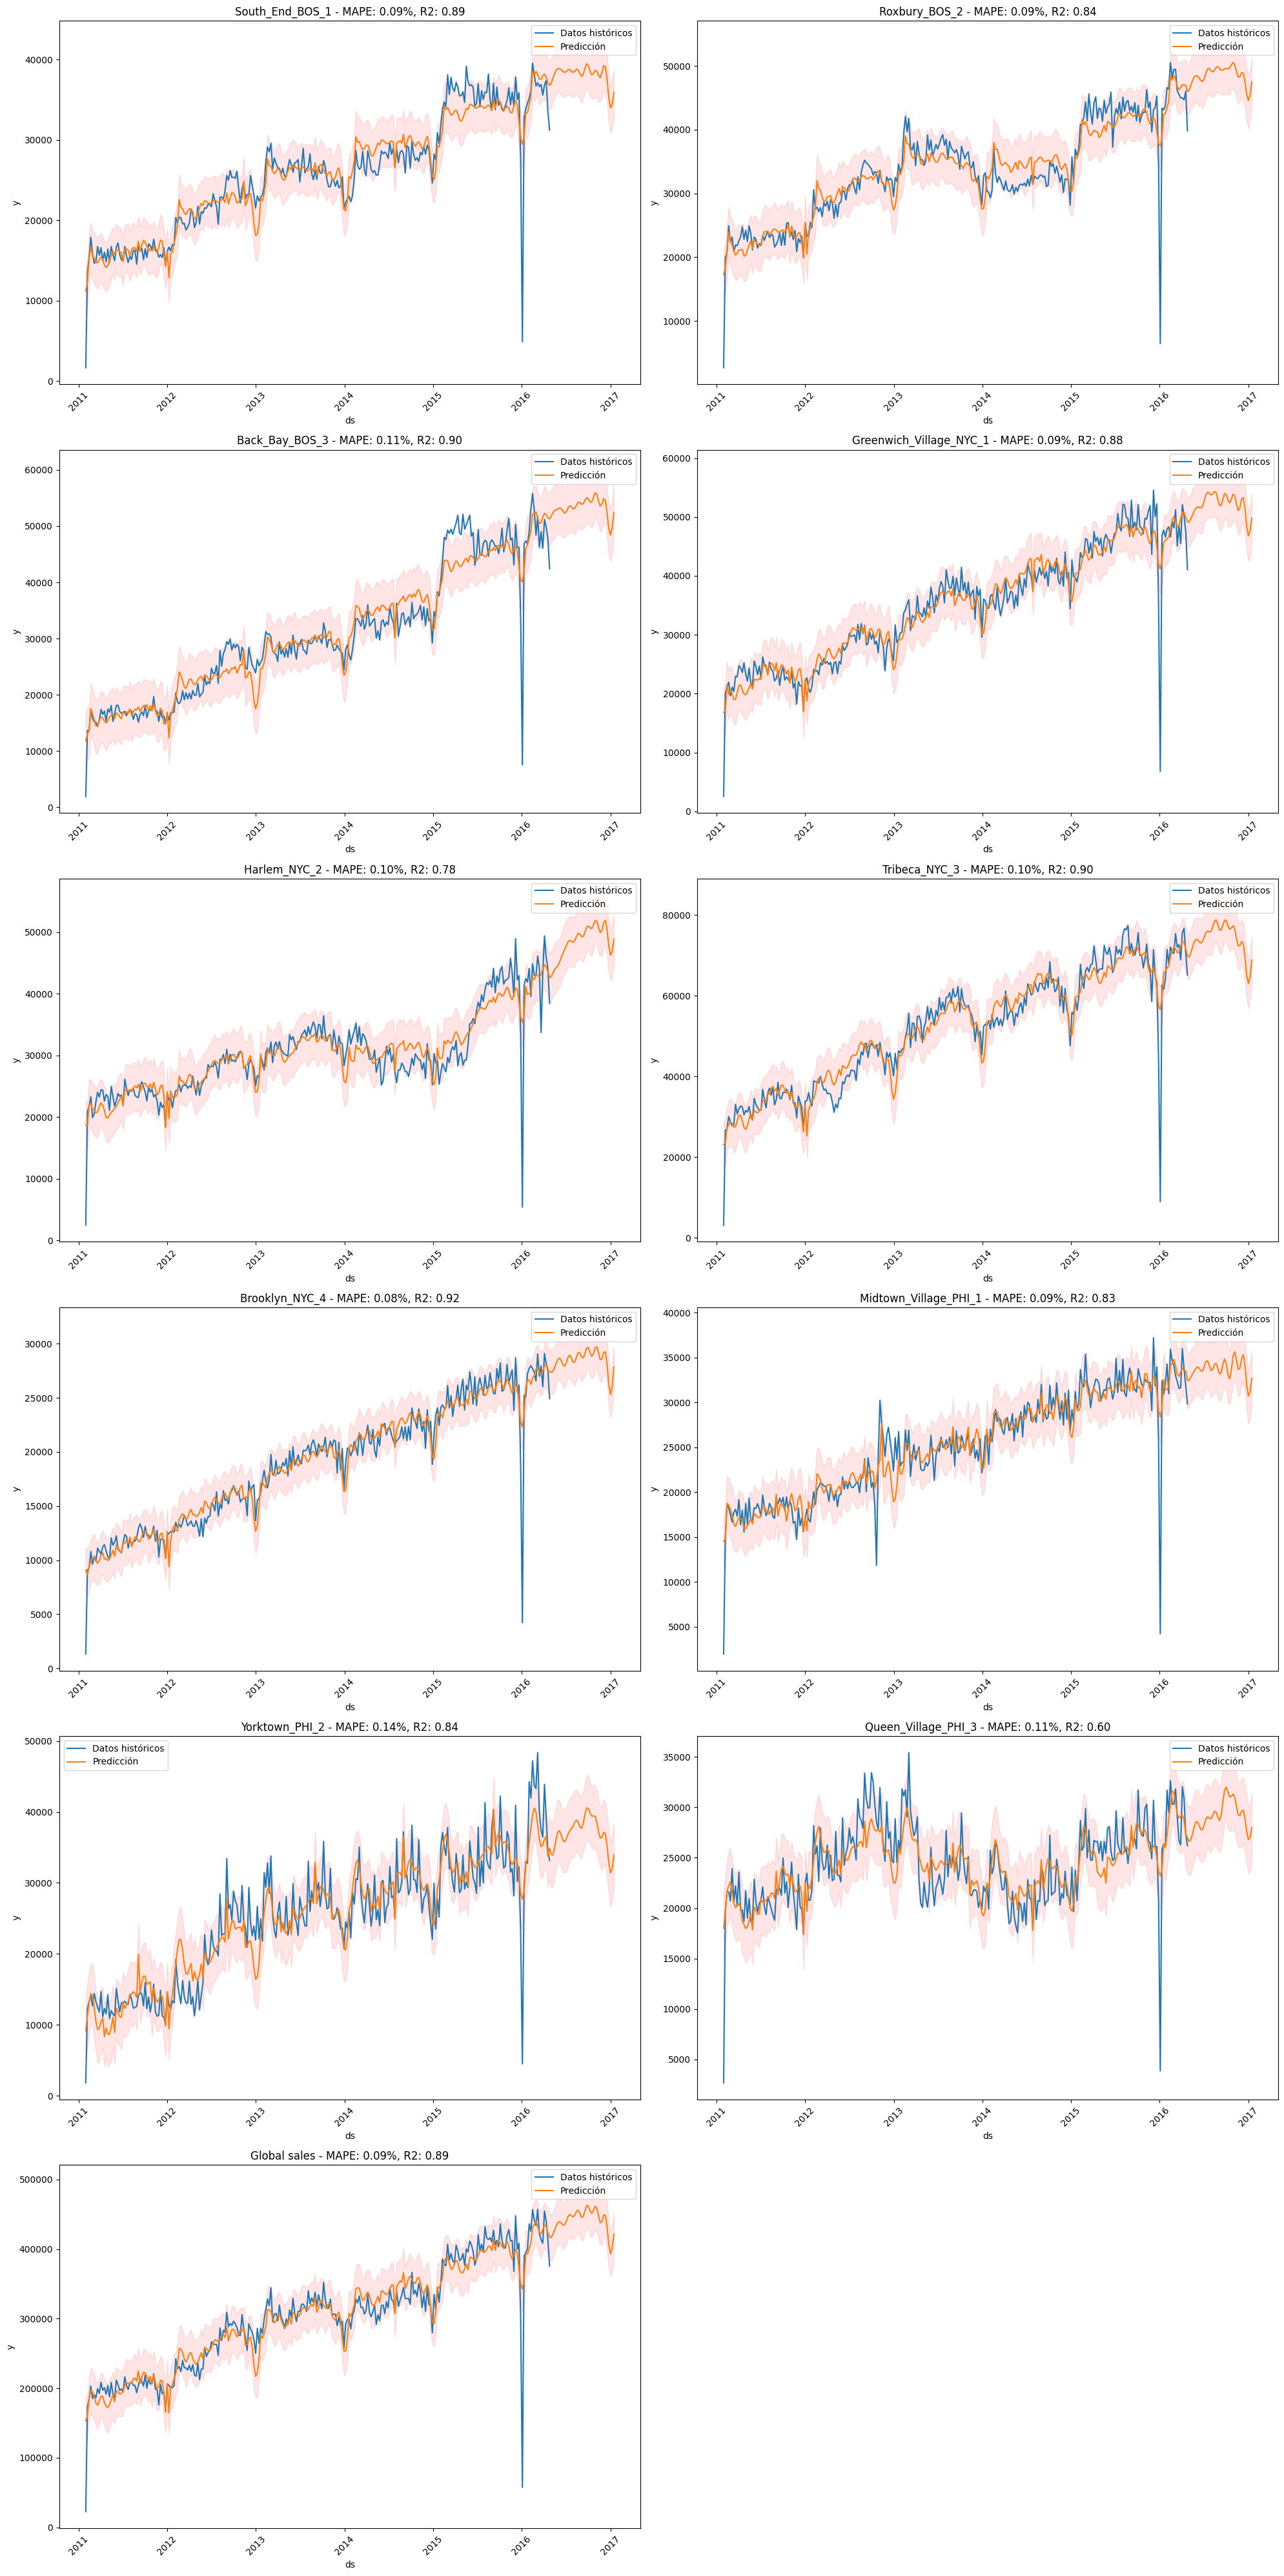

In [77]:
df_cv_hpt_prediccions= prophet_store_prediction_cv(dict_tienda,df_events,38,best_params)

In [46]:
df_pred_BOS_1

NameError: name 'df_pred_BOS_1' is not defined

In [ ]:
# representamos la prediccion respecto a los datos reales


plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1,x='ds',y='y',label='past')

sns.lineplot(data=df_pred_BOS_1,x='ds',y='yhat',label='pred')

In [ ]:
model.plot_components(df_pred_BOS_1)

In [ ]:
# y hacemos la prediccion

df_pred_boston = model.make_future_dataframe(periods=len(df_South_End_BOS_1_test),freq='W')

In [ ]:
# representamos la prediccion respecto a los datos reales

df_pred_boston = model.predict(df_pred_boston)

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_South_End_BOS_1_train.reset_index(),x='date',y='total_sales',label='train')
sns.lineplot(data=df_South_End_BOS_1_test.reset_index(),x='date',y='total_sales',label='test')
sns.lineplot(data=df_pred_boston,x='ds',y='yhat',label='pred')

In [ ]:
# ahora haremos una prediccion para todo el 2016 y mitad del 2017

df_pred_boston_2 = model.make_future_dataframe(periods=80,freq='W')

In [ ]:
df_pred_boston_2 = model.predict(df_pred_boston_2)

plt.figure(figsize=(15, 5))

sns.lineplot(data=df_South_End_BOS_1_train.reset_index(),x='date',y='total_sales',label='train')
sns.lineplot(data=df_South_End_BOS_1_test.reset_index(),x='date',y='total_sales',label='test')
sns.lineplot(data=df_pred_boston_2,x='ds',y='yhat',label='pred')